In [1]:
from UTILITY_quickstart import *

?initializeTao

Signature:
initializeTao(
    filePath=None,
    lastTrackedElement='end',
    csrTF=False,
    inputBeamFilePathSuffix=None,
    numMacroParticles=None,
    loadDefaultLatticeTF=True,
    runImpactTF=False,
    impactGridCount=32,
)
Docstring: <no docstring>
File:      ~/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py
Type:      function

In [2]:
# Initialize Tao and run Impact
tao = initializeTao(
    runImpactTF = True,
    numMacroParticles = 5e3,
    impactGridCount = 8
)

Environment set to:  /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao
Tracking to end
CSR off
Loading default setLattice() values
Running Impact
	 Impact: Autophasing
	 Impact: Distgen
	 Impact: Tracking
Running Impact-T in /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/impact/tmpog6g96mo
/opt/homebrew/anaconda3/envs/bmadclone/bin/ImpactTexe
writing 5000 particles to /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/impact/tmpog6g96mo/partcl.data
Cathode start with cathode_kinetic_energy_ref = 1.0 eV
Cathode start: Replaced Np with 5000 according to initial particles
Cathode start: Replaced Bkenergy with 1.0 according to initial particles
Cathode start: Replaced Temission with 6.932381362599448e-12 according to initial particles
Cathode start: Replaced Tini with -3.478880261265052e-12 according to initial particles
Setting total charge to 1.6000000000000003e-09 C
 !-----------------------------------------------------------
 ! IMPACT-T Parallel Beam Dynamics Tracking Code: V2.3.1
 ! Copyrig

# Numerical optimization - Use first two injector quads to match into linac

In [3]:
#Limit tracking to start of BC20
lastTrackedElement = "BEGBC20"
tao.cmd(f'set beam_init track_end = {lastTrackedElement}') 

trackBeam(tao)

In [4]:
def specificOptimizer(
    self,
    **kwargs
):

    self.totalNumEvals += 1
    self.displayEvals()

    savedData = kwargs
    
    badValue = -1e50 #The value returned for illegal config
    
    try: #This try block deals with bad configurations. Instead of causing the optimizer to halt we now 'except' a low value
        setLattice(tao, **kwargs)

    except:
        return badValue * 5

    try:
        trackBeam(tao)

    except:
        return badValue * 3

    

    P = ParticleGroup(data=tao.bunch_data(lastTrackedElement))
    P = P[P.status == 1]

    savedData["norm_emit_x"] = P["norm_emit_x"]
    savedData["norm_emit_y"] = P["norm_emit_y"]
    maximizeMe = 1 / (savedData["norm_emit_x"] * savedData["norm_emit_y"])    
    savedData["maximizeMe"] = maximizeMe
    
    
    #Collect desired data as a pandas Series
    tmpData = pd.Series( savedData ) 
    self.history = pd.concat([self.history, tmpData.to_frame().T])

    self.updatePlot()

    return maximizeMe



def optimizerWrapper( self,
                     QA10361kG, QA10371kG, 
                     **kwargs ):
    return specificOptimizer(
        self,
        **{
            "QA10361kG": QA10361kG, 
            "QA10371kG": QA10371kG,
        }
    )


class OptimizationProblem:
    def __init__(self):
        self.history = pd.DataFrame()
        self.totalNumEvals = 0
        self.plot_display_handle = None
        self.evals_display_handle = None

        

    def updatePlot(self):
        plt.figure()
        plotKey = "maximizeMe"
        plt.plot(np.arange(len(self.history[plotKey])), self.history[plotKey], '-')
        
        plt.title('Optimization History')
        plt.xlabel('Evaluation #')
        plt.ylabel(plotKey)
        plt.yscale('log')
        plt.grid(True)
        
        
        if self.plot_display_handle is None:
            self.plot_display_handle = display(plt.gcf(), display_id=True)
        else:
            update_display(plt.gcf(), display_id=self.plot_display_handle.display_id)
        plt.close()

    def displayEvals(self):
        if self.evals_display_handle is None:
            self.evals_display_handle = display(f"Total Num Evals: {self.totalNumEvals}", display_id=True)
        else:
            update_display(f"Total Num Evals: {self.totalNumEvals}", display_id=self.evals_display_handle.display_id)

# Attach the function to the class as a method
OptimizationProblem.optimizerWrapper = optimizerWrapper

# Instantiate the optimization problem
problem = OptimizationProblem()

def makeBoundsTuple(range, center): return tuple(sorted( ( (1-range)*center, (1+range)*center) ) )
#boundsRange = 0.5
quadBoundsRange = 0.25
sextBoundsRange = 0.5

# Bounded region of parameter space
#2024-05-15: Out of abundance of caution, always comment out unused vars, even if using **kwargs stops errors from being thrown
pbounds = {
    "QA10361kG": (-5,0),
    "QA10371kG": (0,5),
}

'Total Num Evals: 28'

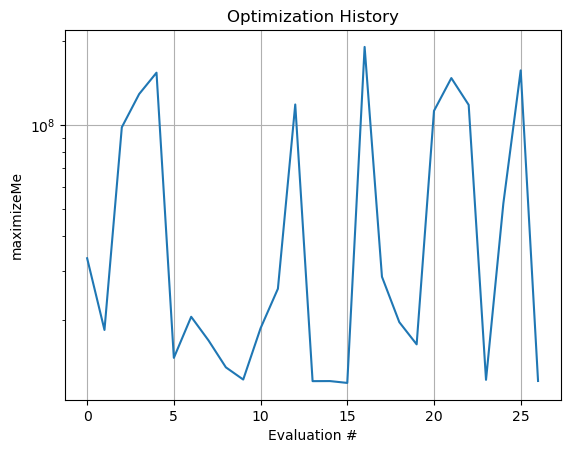

differential_evolution step 1: f(x)= -1.54189e+08
differential_evolution step 2: f(x)= -1.90792e+08
differential_evolution step 3: f(x)= -1.90792e+08


In [ ]:
from scipy.optimize import differential_evolution

# Convert pbounds to the format required by differential_evolution
bounds = [(low, high) for (low, high) in pbounds.values()]
param_names = list(pbounds.keys())

#Optional: Define list of starting points
totalPopSize = 5  # Total population size
numDimensions = len(bounds)  # Number of parameters




#Uniformly distributed
# populationDE = np.random.rand(totalPopSize, numDimensions)
# for i in range(numDimensions):
#     low, high = bounds[i]
#     populationDE[:, i] = low + populationDE[:, i] * (high - low)

#Normally distributed
populationDE = np.zeros((totalPopSize, numDimensions))
for i in range(numDimensions):
    low, high = bounds[i]
    mean = (high + low) / 2
    std_dev = (high - low) / 10
    populationDE[:, i] = np.random.normal(mean, std_dev, totalPopSize)

#Optional: Add specific points to initial evaluation list
populationDE = np.vstack([populationDE, [ np.mean(i) for i in bounds ]])

#scipy.optimize wants to optimize a function which is passed a vector of all the parameters
#This programmatically wraps the existing wrapper (ugh...) to handle this format
def create_DE_wrapper(obj, param_names):
    def wrapperDE(params):
        param_dict = dict(zip(param_names, params))

        #bayes_opt is a maximizer but differential_evoluation is a minimizer... hence the inversion
        return -1*obj.optimizerWrapper(**param_dict)
    
    return wrapperDE

wrapperDE = create_DE_wrapper(problem, param_names)

result = differential_evolution(
    wrapperDE, 
    bounds,
    #strategy='best1bin', 
    maxiter=50, #Actual number of evals = maxiter * num dimensions * popsize
    #popsize=1, #Actual population = num (unequal) dimensions * popsize
    #tol=0.01, 
    #mutation=(0.5, 1), 
    #recombination=0.7, 
    disp=True,
    polish = False, 
    init = populationDE #"sobol" #Default is "latinhypercube"
)



print(problem.history)

## Check out results

In [ ]:
problem.history.to_csv('output_data.csv', index=False)
problem.history.to_json('output_data.json', orient="records")

problem.history = problem.history.sort_values(by='maximizeMe', ascending=False)


bestConfigData = problem.history.iloc[0]
bestConfigDict = bestConfigData.to_dict()

print( bestConfigData ) 

setLattice(tao, **bestConfigDict)


trackBeam(tao)

P = ParticleGroup(data=tao.bunch_data(lastTrackedElement))
P = P[P.status == 1]

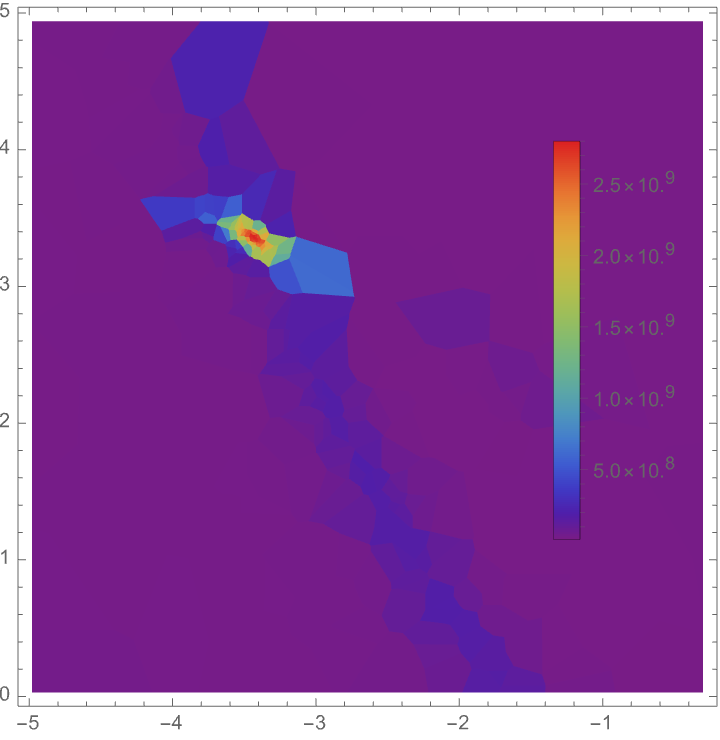

# Numerical optimization - Use six injector quads to match into linac

In [ ]:
def optimizerWrapper( self,
                     QA10361kG, QA10371kG, 
                     QE10425kG, QE10441kG, 
                     QE10511kG, QE10525kG
                     **kwargs ):
    return specificOptimizer(
        self,
        **{
            "QA10361kG": QA10361kG, 
            "QA10371kG": QA10371kG,

            "QE10425kG": QE10425kG,
            "QE10441kG": QE10441kG,

            "QE10511kG": QE10511kG,
            "QE10525kG": QE10525kG,
        }
    )


class OptimizationProblem:
    def __init__(self):
        self.history = pd.DataFrame()
        self.totalNumEvals = 0
        self.plot_display_handle = None
        self.evals_display_handle = None

        

    def updatePlot(self):
        plt.figure()
        plotKey = "maximizeMe"
        plt.plot(np.arange(len(self.history[plotKey])), self.history[plotKey], '-')
        
        plt.title('Optimization History')
        plt.xlabel('Evaluation #')
        plt.ylabel(plotKey)
        plt.yscale('log')
        plt.grid(True)
        
        
        if self.plot_display_handle is None:
            self.plot_display_handle = display(plt.gcf(), display_id=True)
        else:
            update_display(plt.gcf(), display_id=self.plot_display_handle.display_id)
        plt.close()

    def displayEvals(self):
        if self.evals_display_handle is None:
            self.evals_display_handle = display(f"Total Num Evals: {self.totalNumEvals}", display_id=True)
        else:
            update_display(f"Total Num Evals: {self.totalNumEvals}", display_id=self.evals_display_handle.display_id)

# Attach the function to the class as a method
OptimizationProblem.optimizerWrapper = optimizerWrapper

# Instantiate the optimization problem
problem = OptimizationProblem()

def makeBoundsTuple(range, center): return tuple(sorted( ( (1-range)*center, (1+range)*center) ) )
#boundsRange = 0.5
quadBoundsRange = 0.25
sextBoundsRange = 0.5

# Bounded region of parameter space
#2024-05-15: Out of abundance of caution, always comment out unused vars, even if using **kwargs stops errors from being thrown
pbounds = {
    "QA10361kG": (-5,0),
    "QA10371kG": (0,5),

    "QE10425kG": (-15,0),
    "QE10441kG": (0,5),

    "QE10511kG": (0,10),
    "QE10525kG": (-10,0),
}

In [ ]:
from scipy.optimize import differential_evolution

# Convert pbounds to the format required by differential_evolution
bounds = [(low, high) for (low, high) in pbounds.values()]
param_names = list(pbounds.keys())

#Optional: Define list of starting points
totalPopSize = 50  # Total population size
numDimensions = len(bounds)  # Number of parameters




#Uniformly distributed
# populationDE = np.random.rand(totalPopSize, numDimensions)
# for i in range(numDimensions):
#     low, high = bounds[i]
#     populationDE[:, i] = low + populationDE[:, i] * (high - low)

#Normally distributed
populationDE = np.zeros((totalPopSize, numDimensions))
for i in range(numDimensions):
    low, high = bounds[i]
    mean = (high + low) / 2
    std_dev = (high - low) / 10
    populationDE[:, i] = np.random.normal(mean, std_dev, totalPopSize)

#Optional: Add specific points to initial evaluation list
populationDE = np.vstack([populationDE, [ np.mean(i) for i in bounds ]])

#scipy.optimize wants to optimize a function which is passed a vector of all the parameters
#This programmatically wraps the existing wrapper (ugh...) to handle this format
def create_DE_wrapper(obj, param_names):
    def wrapperDE(params):
        param_dict = dict(zip(param_names, params))

        #bayes_opt is a maximizer but differential_evoluation is a minimizer... hence the inversion
        return -1*obj.optimizerWrapper(**param_dict)
    
    return wrapperDE

wrapperDE = create_DE_wrapper(problem, param_names)

result = differential_evolution(
    wrapperDE, 
    bounds,
    #strategy='best1bin', 
    maxiter=50, #Actual number of evals = maxiter * num dimensions * popsize
    #popsize=1, #Actual population = num (unequal) dimensions * popsize
    #tol=0.01, 
    #mutation=(0.5, 1), 
    #recombination=0.7, 
    disp=True,
    polish = False, 
    init = populationDE #"sobol" #Default is "latinhypercube"
)



print(problem.history)

## Check out results

In [ ]:
problem.history.to_csv('output_data.csv', index=False)
problem.history.to_json('output_data.json', orient="records")

problem.history = problem.history.sort_values(by='maximizeMe', ascending=False)


bestConfigData = problem.history.iloc[0]
bestConfigDict = bestConfigData.to_dict()

print( bestConfigData ) 

setLattice(tao, **bestConfigDict)


trackBeam(tao)

P = ParticleGroup(data=tao.bunch_data(lastTrackedElement))
P = P[P.status == 1]

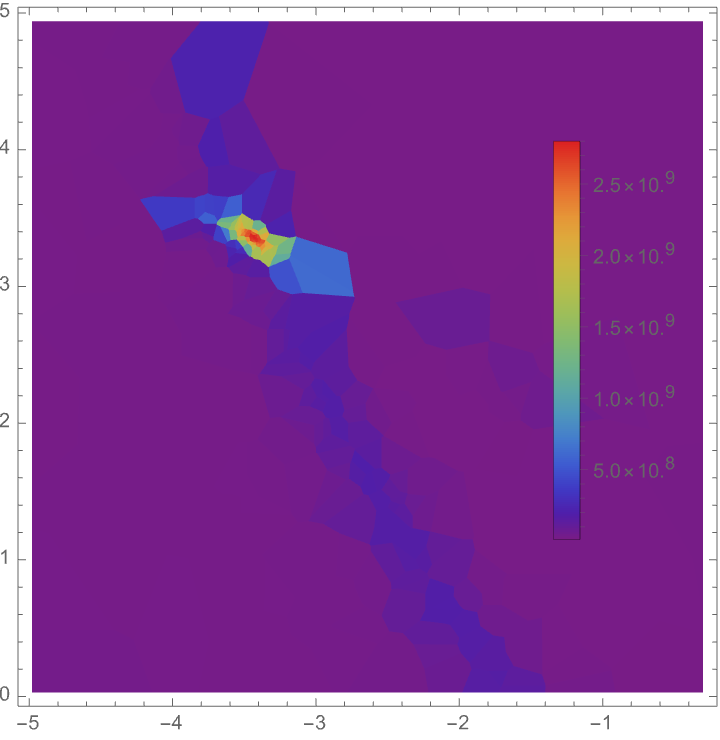